# MLflow Experiment Tracking
# Seguimiento de Experimentos con MLflow

Este notebook demuestra cómo usar MLflow para el seguimiento de experimentos de machine learning usando los datos del proyecto Practical Statistics for Data Scientists.

## Objetivos:
- Configurar MLflow para seguimiento de experimentos
- Entrenar múltiples modelos de clasificación
- Registrar parámetros, métricas y artefactos
- Comparar diferentes modelos y configuraciones
- Usar MLflow UI para visualizar resultados

## Instalación de MLflow

Si no tienes MLflow instalado, descomenta y ejecuta la siguiente celda:

In [29]:
# !pip install mlflow
# %pip install -U mlflow

## Importar librerías necesarias

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("📚 Librerías importadas exitosamente")
print(f"🔬 MLflow versión: {mlflow.__version__}")

📚 Librerías importadas exitosamente
🔬 MLflow versión: 3.2.0


## Configuración de MLflow

In [48]:
from mlflow.tracking import MlflowClient
#Que store de mklflow estoy usando 
import mlflow, os
print("mlflow.get_tracking_uri():", mlflow.get_tracking_uri())
print("MLFLOW_TRACKING_URI env:", os.environ.get("MLFLOW_TRACKING_URI"))

#Import MLflow utils 
import ds_utils
from ds_utils import MLflowUtils

mlflow_uri = "http://127.0.0.1:5000"
mlflow_experiment = "Loan Default Classification"

mlflow_utils = MLflowUtils()
mlflow_utils.init_mlflow(mlflow_uri, mlflow_experiment)



mlflow.get_tracking_uri(): http://127.0.0.1:5000
MLFLOW_TRACKING_URI env: http://127.0.0.1:5000
Create or use experiment: Loan Default Classification


In [36]:
from mlflow.tracking import MlflowClient
#Que store de mklflow estoy usando 
import mlflow, os
print("mlflow.get_tracking_uri():", mlflow.get_tracking_uri())
print("MLFLOW_TRACKING_URI env:", os.environ.get("MLFLOW_TRACKING_URI"))

#Import MLflow utils 
from ds_utils import MLflowUtils

# Configurar MLflow
mlflow_uri = "http://127.0.0.1:5000"
mlflow_experiment = "Loan Default Classification"

mlflow_utils = MLflowUtils()
mlflow_utils.init_mlflow(mlflow_uri, mlflow_experiment)

# Obtener información del experimento
experiment = mlflow.get_experiment_by_name(mlflow_experiment)
print(f"🔬 Experimento: {experiment.name}")
print(f"📁 Experiment ID: {experiment.experiment_id}")
print(f"📂 Artifact Location: {experiment.artifact_location}")



mlflow.get_tracking_uri(): http://127.0.0.1:5000
MLFLOW_TRACKING_URI env: http://127.0.0.1:5000
Create or use experiment: Loan Default Classification
🔬 Experimento: Loan Default Classification
📁 Experiment ID: 5
📂 Artifact Location: file:C:/Users/sergiosal/source/repos/DataScienceVSCode/artifacts/5


## Carga y preparación de datos

In [49]:
# Cargar datos
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = './data'

print(DATA)

# Cargar dataset de préstamos
loan_data = pd.read_csv(f'{DATA}/loan3000.csv')

print(f"📊 Dataset cargado: {loan_data.shape[0]} filas, {loan_data.shape[1]} columnas")
print(f"🎯 Variables objetivo: {loan_data['outcome'].value_counts().to_dict()}")

# Mostrar primeras filas
loan_data.head()

./data
📊 Dataset cargado: 3000 filas, 6 columnas
🎯 Variables objetivo: {'paid off': 1555, 'default': 1445}


,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [50]:
# Exploración rápida de datos
print("📈 Información del dataset:")
print(loan_data.info())
print("\n📊 Estadísticas descriptivas:")
print(loan_data.describe())

📈 Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3000 non-null   int64  
 1   outcome            3000 non-null   object 
 2   purpose_           3000 non-null   object 
 3   dti                3000 non-null   float64
 4   borrower_score     3000 non-null   float64
 5   payment_inc_ratio  3000 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 140.8+ KB
None

📊 Estadísticas descriptivas:
        Unnamed: 0          dti  borrower_score  payment_inc_ratio
count   3000.00000  3000.000000     3000.000000        3000.000000
mean   23512.43700    16.120103        0.502333           8.137902
std    13356.37535     7.590890        0.128297           4.296310
min       59.00000     0.000000        0.100000           0.221906
25%    11690.00000    10.362500        0.400000  

## Preparación de datos para ML

In [51]:
# Preparar datos para machine learning
# Seleccionar características numéricas
features = ['borrower_score', 'payment_inc_ratio']
target = 'outcome'

X = loan_data[features]
y = loan_data[target]

# Codificar variable objetivo
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"📊 Datos de entrenamiento: {X_train.shape[0]} muestras")
print(f"📊 Datos de prueba: {X_test.shape[0]} muestras")
print(f"🏷️ Clases: {le.classes_}")

📊 Datos de entrenamiento: 2400 muestras
📊 Datos de prueba: 600 muestras
🏷️ Clases: ['default' 'paid off']


## Función para entrenar y registrar modelos

In [52]:
def train_and_log_model(model, model_name, X_train, X_test, y_train, y_test, params=None):
    """
    Entrena un modelo y registra métricas en MLflow
    """
    with mlflow.start_run(run_name=model_name):
        # Registrar parámetros
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("train_samples", len(X_train))
        mlflow.log_param("test_samples", len(X_test))
        mlflow.log_param("features", list(X_train.columns) if hasattr(X_train, 'columns') else "scaled_features")
        
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Entrenar modelo
        model.fit(X_train, y_train)
        
        # Predicciones
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Registrar métricas
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # AUC si hay probabilidades
        if y_pred_proba is not None:
            auc = roc_auc_score(y_test, y_pred_proba)
            mlflow.log_metric("auc", auc)
        
        # Cross-validation score
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        mlflow.log_metric("cv_mean", cv_scores.mean())
        mlflow.log_metric("cv_std", cv_scores.std())
        
        # Registrar modelo
        mlflow.sklearn.log_model(model, "model")
        
        # Crear y guardar matriz de confusión
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(f'Matriz de Confusión - {model_name}')
        plt.xlabel('Predicción')
        plt.ylabel('Actual')
        plt.tight_layout()
        
        # Guardar gráfico como artefacto
        plt.savefig(f"confusion_matrix_{model_name.replace(' ', '_')}.png")
        mlflow.log_artifact(f"confusion_matrix_{model_name.replace(' ', '_')}.png")
        plt.show()
        
        # Registrar reporte de clasificación
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
        
        # Crear archivo de texto con el reporte
        with open(f"classification_report_{model_name.replace(' ', '_')}.txt", "w") as f:
            f.write(classification_report(y_test, y_pred, target_names=le.classes_))
        mlflow.log_artifact(f"classification_report_{model_name.replace(' ', '_')}.txt")
        
        print(f"✅ {model_name} entrenado y registrado en MLflow")
        print(f"📊 Accuracy: {accuracy:.4f}")
        print(f"📊 F1-Score: {f1:.4f}")
        if y_pred_proba is not None:
            print(f"📊 AUC: {auc:.4f}")
        print("-" * 50)
        
        return model

## Entrenar múltiples modelos

🚀 Iniciando entrenamiento de modelos con MLflow...

🔄 Entrenando Logistic Regression...


2025/08/12 02:46:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:46:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


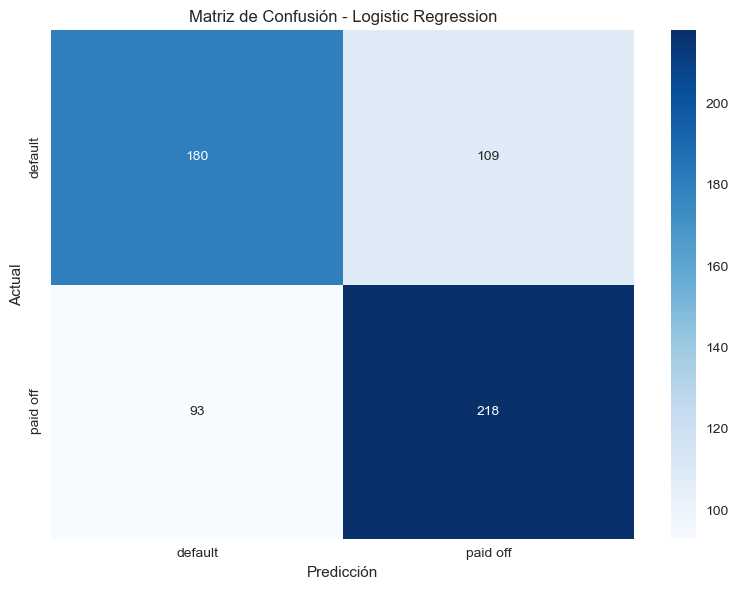

✅ Logistic Regression entrenado y registrado en MLflow
📊 Accuracy: 0.6633
📊 F1-Score: 0.6628
📊 AUC: 0.7177
--------------------------------------------------
🏃 View run Logistic Regression at: http://127.0.0.1:5000/#/experiments/5/runs/e0656a782aa44cb8a03fd58180737961
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Random Forest...


2025/08/12 02:46:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:46:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


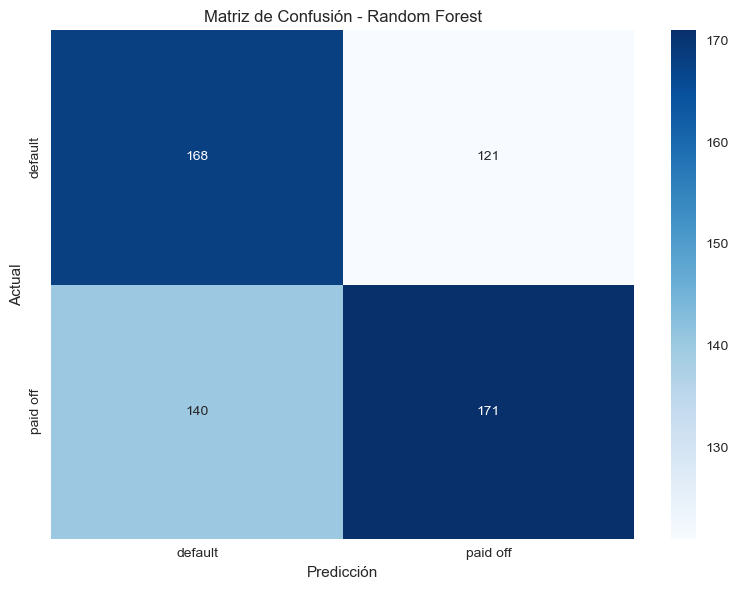

✅ Random Forest entrenado y registrado en MLflow
📊 Accuracy: 0.5650
📊 F1-Score: 0.5651
📊 AUC: 0.6173
--------------------------------------------------
🏃 View run Random Forest at: http://127.0.0.1:5000/#/experiments/5/runs/09229e7306ae4ac7bd235cd92364688f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Support Vector Machine...


2025/08/12 02:46:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:46:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


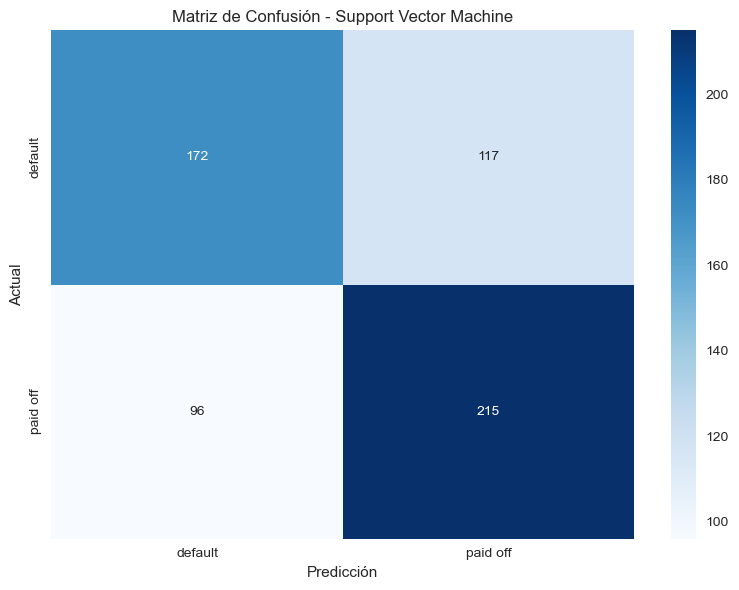

✅ Support Vector Machine entrenado y registrado en MLflow
📊 Accuracy: 0.6450
📊 F1-Score: 0.6441
📊 AUC: 0.7006
--------------------------------------------------
🏃 View run Support Vector Machine at: http://127.0.0.1:5000/#/experiments/5/runs/6def4df1a76f47758ff61132b5c62018
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Naive Bayes...


2025/08/12 02:46:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:47:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


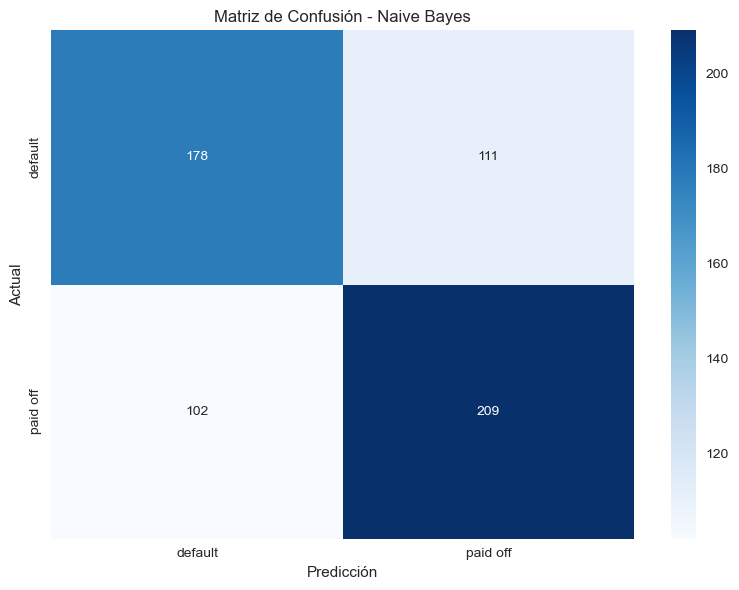

✅ Naive Bayes entrenado y registrado en MLflow
📊 Accuracy: 0.6450
📊 F1-Score: 0.6447
📊 AUC: 0.7159
--------------------------------------------------
🏃 View run Naive Bayes at: http://127.0.0.1:5000/#/experiments/5/runs/6f36b511812e40e2a55a32597a42f3af
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Decision Tree...


2025/08/12 02:47:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:47:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


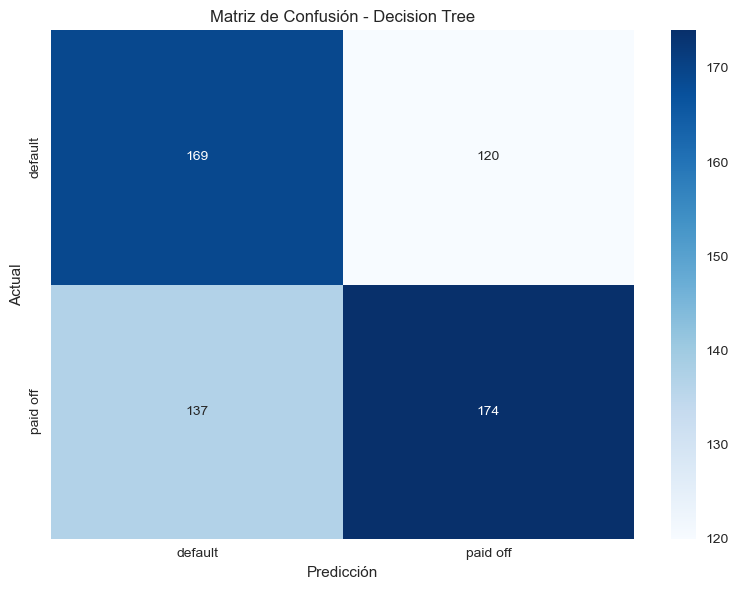

✅ Decision Tree entrenado y registrado en MLflow
📊 Accuracy: 0.5717
📊 F1-Score: 0.5718
📊 AUC: 0.5721
--------------------------------------------------
🏃 View run Decision Tree at: http://127.0.0.1:5000/#/experiments/5/runs/3f99ede5cdc1480d8d937697ab0e4cc9
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando K-Nearest Neighbors...


2025/08/12 02:47:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:47:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


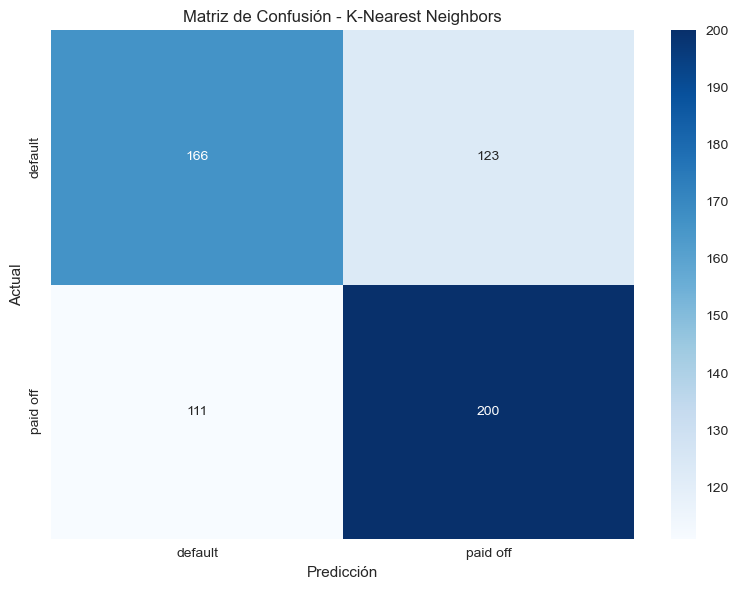

✅ K-Nearest Neighbors entrenado y registrado en MLflow
📊 Accuracy: 0.6100
📊 F1-Score: 0.6096
📊 AUC: 0.6406
--------------------------------------------------
🏃 View run K-Nearest Neighbors at: http://127.0.0.1:5000/#/experiments/5/runs/707b05783639424da32eec6cabbe4348
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Gradient Boosting...


2025/08/12 02:47:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:47:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


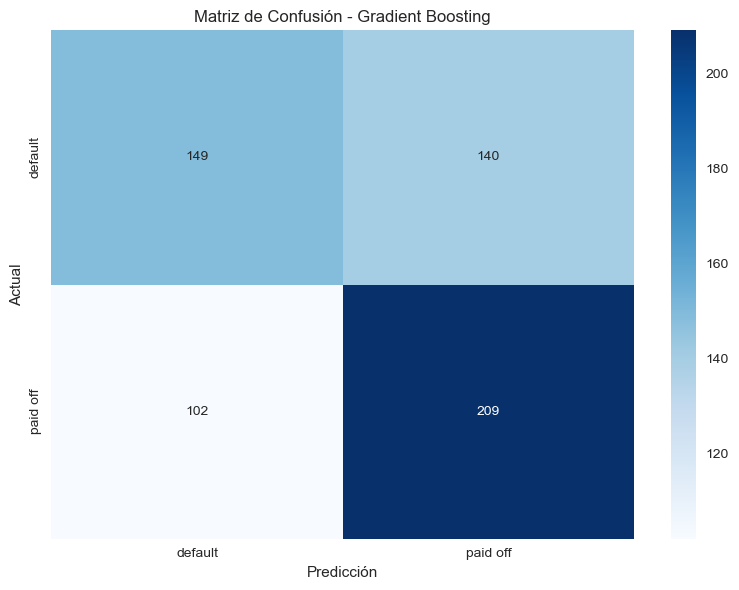

✅ Gradient Boosting entrenado y registrado en MLflow
📊 Accuracy: 0.5967
📊 F1-Score: 0.5941
📊 AUC: 0.6772
--------------------------------------------------
🏃 View run Gradient Boosting at: http://127.0.0.1:5000/#/experiments/5/runs/de44d03c7a964e3eb9640b47f201cf73
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Ridge Classifier...


2025/08/12 02:47:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:47:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


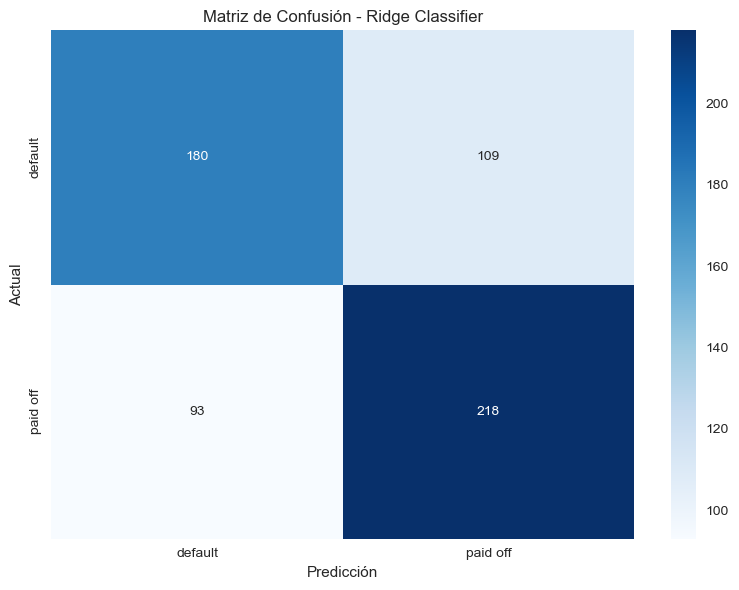

✅ Ridge Classifier entrenado y registrado en MLflow
📊 Accuracy: 0.6633
📊 F1-Score: 0.6628
--------------------------------------------------
🏃 View run Ridge Classifier at: http://127.0.0.1:5000/#/experiments/5/runs/2fb613bb217d499d80b200822d902ebb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5
🔄 Entrenando Decision Tree...


2025/08/12 02:47:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:47:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


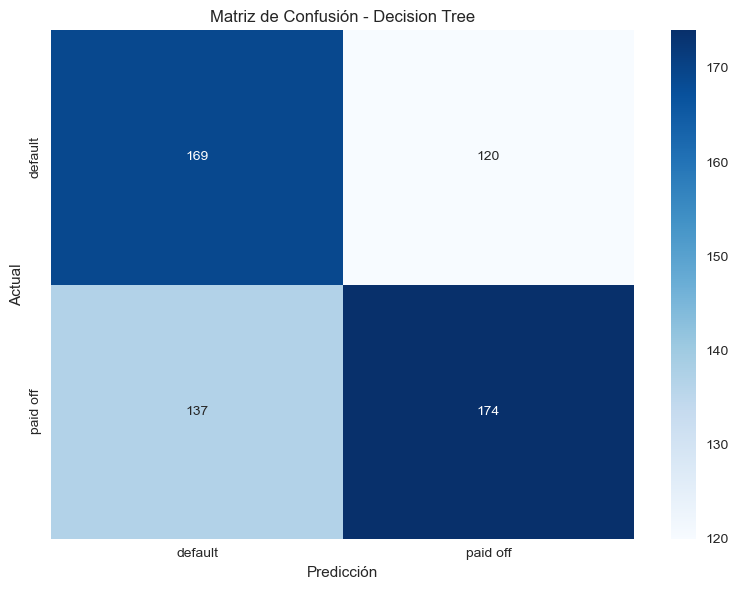

✅ Decision Tree entrenado y registrado en MLflow
📊 Accuracy: 0.5717
📊 F1-Score: 0.5718
📊 AUC: 0.5721
--------------------------------------------------
🏃 View run Decision Tree at: http://127.0.0.1:5000/#/experiments/5/runs/a458c3f0d6ba47249de4edcfcc9a6147
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/5

🎉 ¡Todos los modelos han sido entrenados y registrados!


In [53]:
# Definir modelos a probar

models_to_test = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression", 
     {"C": 1.0, "solver": "liblinear", "multi_class": "ovr"}),
    
    (RandomForestClassifier(random_state=42), "Random Forest", 
     {"n_estimators": 100, "max_depth": None, "min_samples_split": 2}),
    
    (SVC(random_state=42, probability=True), "Support Vector Machine", 
     {"C": 1.0, "kernel": "rbf", "gamma": "scale"}),
    
    (GaussianNB(), "Naive Bayes", {"var_smoothing": 1e-9}),
    
    (DecisionTreeClassifier(random_state=42), "Decision Tree", 
     {"max_depth": None, "min_samples_split": 2, "criterion": "gini"}),
    
    (KNeighborsClassifier(), "K-Nearest Neighbors", 
     {"n_neighbors": 5, "weights": "uniform", "algorithm": "auto"}),
    
    (GradientBoostingClassifier(random_state=42), "Gradient Boosting", 
     {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3}),
    
    (RidgeClassifier(random_state=42), "Ridge Classifier", 
     {"alpha": 1.0, "solver": "auto"}),
    
    (DecisionTreeClassifier(random_state=42), "Decision Tree", 
     {"max_depth": None, "min_samples_split": 2})
]

print("🚀 Iniciando entrenamiento de modelos con MLflow...\n")

trained_models = {}

for model, name, params in models_to_test:
    print(f"🔄 Entrenando {name}...")
    trained_model = train_and_log_model(
        model, name, 
        pd.DataFrame(X_train_scaled, columns=features), 
        pd.DataFrame(X_test_scaled, columns=features),
        y_train, y_test, params
    )
    trained_models[name] = trained_model

print("\n🎉 ¡Todos los modelos han sido entrenados y registrados!")

## Experimento con hiperparámetros

🔬 Experimentando con hiperparámetros de Random Forest...

🌳 Probando Random Forest - Config 1 con parámetros: {'n_estimators': 50, 'max_depth': 5}


2025/08/12 02:08:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:08:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


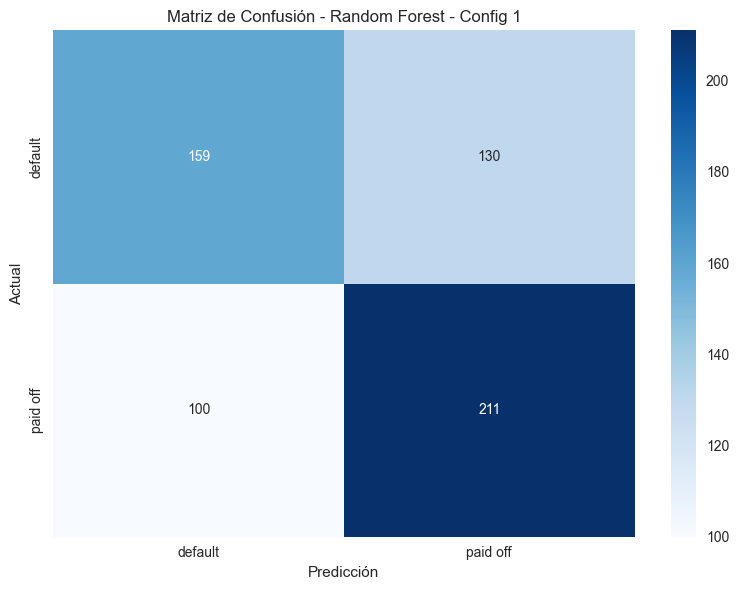

✅ Random Forest - Config 1 entrenado y registrado en MLflow
📊 Accuracy: 0.6167
📊 F1-Score: 0.6150
📊 AUC: 0.6980
--------------------------------------------------
🌳 Probando Random Forest - Config 2 con parámetros: {'n_estimators': 100, 'max_depth': 10}


2025/08/12 02:08:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:08:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


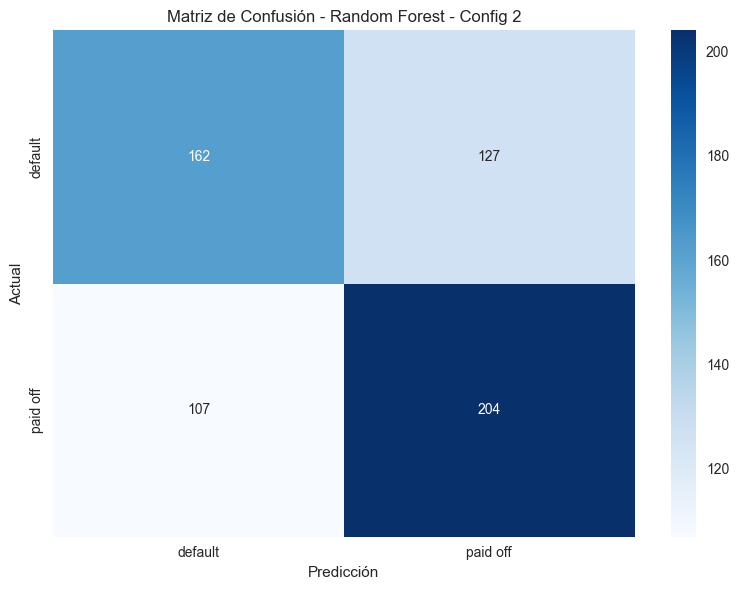

✅ Random Forest - Config 2 entrenado y registrado en MLflow
📊 Accuracy: 0.6100
📊 F1-Score: 0.6091
📊 AUC: 0.6537
--------------------------------------------------
🌳 Probando Random Forest - Config 3 con parámetros: {'n_estimators': 200, 'max_depth': 15}


2025/08/12 02:08:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:08:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


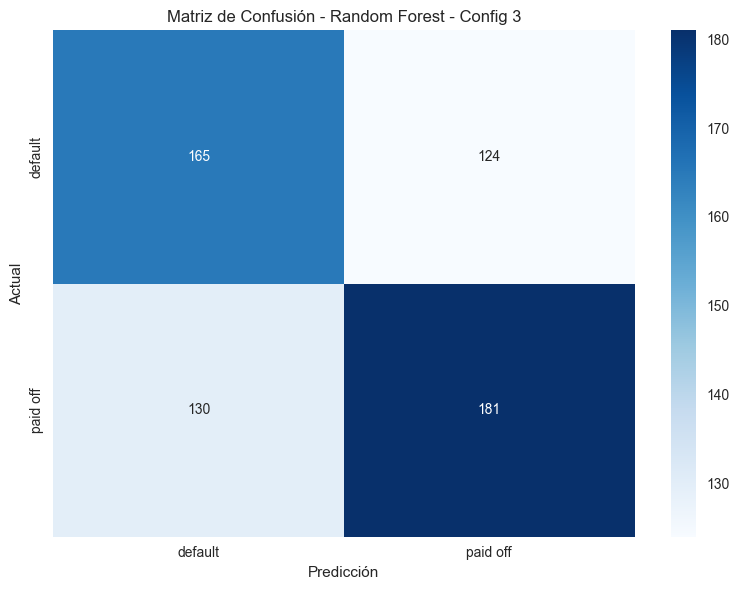

✅ Random Forest - Config 3 entrenado y registrado en MLflow
📊 Accuracy: 0.5767
📊 F1-Score: 0.5768
📊 AUC: 0.6313
--------------------------------------------------
🌳 Probando Random Forest - Config 4 con parámetros: {'n_estimators': 150, 'max_depth': None}


2025/08/12 02:08:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/12 02:09:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


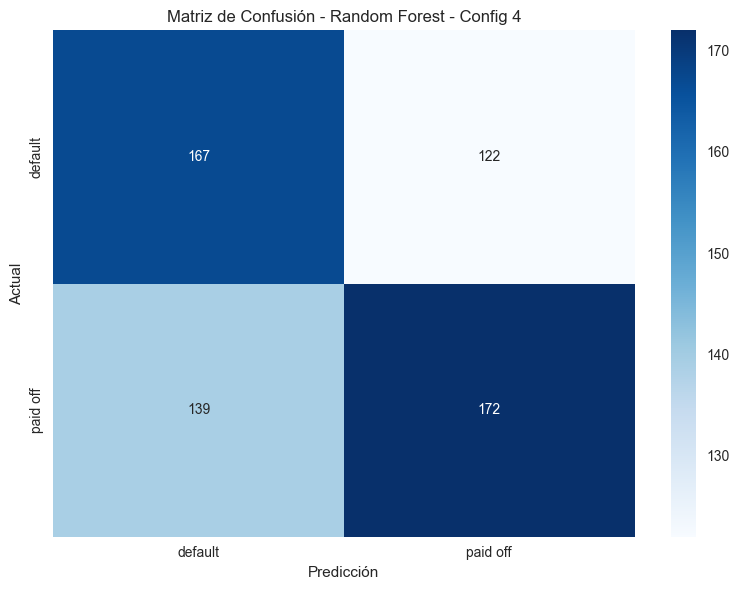

✅ Random Forest - Config 4 entrenado y registrado en MLflow
📊 Accuracy: 0.5650
📊 F1-Score: 0.5651
📊 AUC: 0.6204
--------------------------------------------------

✅ Experimentos con hiperparámetros completados!


In [33]:
# Probar diferentes hiperparámetros para Random Forest
print("🔬 Experimentando con hiperparámetros de Random Forest...\n")

rf_params = [
    {"n_estimators": 50, "max_depth": 5},
    {"n_estimators": 100, "max_depth": 10},
    {"n_estimators": 200, "max_depth": 15},
    {"n_estimators": 150, "max_depth": None}
]

for i, params in enumerate(rf_params):
    model = RandomForestClassifier(random_state=42, **params)
    model_name = f"Random Forest - Config {i+1}"
    
    print(f"🌳 Probando {model_name} con parámetros: {params}")
    train_and_log_model(
        model, model_name,
        pd.DataFrame(X_train_scaled, columns=features),
        pd.DataFrame(X_test_scaled, columns=features),
        y_train, y_test, params
    )

print("\n✅ Experimentos con hiperparámetros completados!")

## Consultar experimentos registrados

In [35]:
# Obtener todos los runs del experimento
client = MlflowClient()
experiment = mlflow.get_experiment_by_name(experiment_name)
runs = client.search_runs(experiment.experiment_id)

print(f"📊 Total de runs en el experimento: {len(runs)}")
print("\n🏆 Resumen de resultados:")
print("-" * 80)

# Crear DataFrame con resultados
results_data = []
for run in runs:
    metrics = run.data.metrics
    params = run.data.params
    
    results_data.append({
        'run_id': run.info.run_id[:8],
        'model_type': params.get('model_type', 'Unknown'),
        'accuracy': metrics.get('accuracy', 0),
        'f1_score': metrics.get('f1_score', 0),
        'auc': metrics.get('auc', 0),
        'cv_mean': metrics.get('cv_mean', 0),
        'start_time': run.info.start_time
    })

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('accuracy', ascending=False)

print(results_df.to_string(index=False))

# Mejor modelo
best_model = results_df.iloc[0]
print(f"\n🥇 Mejor modelo: {best_model['model_type']}")
print(f"📊 Accuracy: {best_model['accuracy']:.4f}")
print(f"📊 F1-Score: {best_model['f1_score']:.4f}")
print(f"📊 AUC: {best_model['auc']:.4f}")

📊 Total de runs en el experimento: 13

🏆 Resumen de resultados:
--------------------------------------------------------------------------------
  run_id               model_type  accuracy  f1_score      auc  cv_mean    start_time
dbccd723         Ridge Classifier  0.663333  0.662762 0.000000 0.616667 1754975204838
0e820d5d      Logistic Regression  0.663333  0.662762 0.717693 0.617500 1754975170867
6edaa692              Naive Bayes  0.645000  0.644724 0.715901 0.621250 1754975190059
a466d69f   Support Vector Machine  0.645000  0.644105 0.700636 0.615000 1754975184170
adfd6699 Random Forest - Config 1  0.616667  0.614993 0.697955 0.605000 1754975323023
eb26dd6e      K-Nearest Neighbors  0.610000  0.609557 0.640556 0.568333 1754975196844
502be07a Random Forest - Config 2  0.610000  0.609086 0.653657 0.587083 1754975326641
2ed1d579        Gradient Boosting  0.596667  0.594086 0.677222 0.604583 1754975200526
7d2afe63 Random Forest - Config 3  0.576667  0.576780 0.631276 0.565833 175497533

## Visualización de resultados

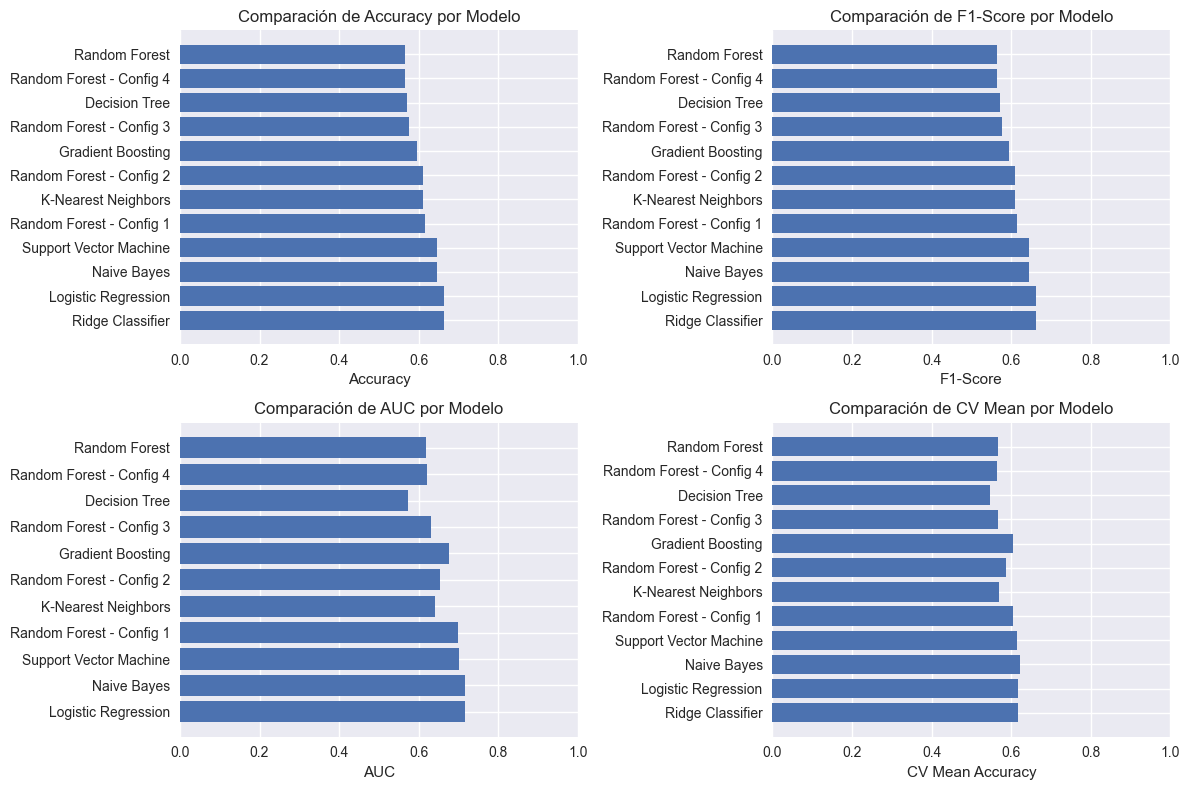

In [36]:
# Gráfico de comparación de modelos
plt.figure(figsize=(12, 8))

# Subplot 1: Accuracy
plt.subplot(2, 2, 1)
plt.barh(results_df['model_type'], results_df['accuracy'])
plt.xlabel('Accuracy')
plt.title('Comparación de Accuracy por Modelo')
plt.xlim(0, 1)

# Subplot 2: F1-Score
plt.subplot(2, 2, 2)
plt.barh(results_df['model_type'], results_df['f1_score'])
plt.xlabel('F1-Score')
plt.title('Comparación de F1-Score por Modelo')
plt.xlim(0, 1)

# Subplot 3: AUC
plt.subplot(2, 2, 3)
auc_data = results_df[results_df['auc'] > 0]  # Solo modelos con AUC
plt.barh(auc_data['model_type'], auc_data['auc'])
plt.xlabel('AUC')
plt.title('Comparación de AUC por Modelo')
plt.xlim(0, 1)

# Subplot 4: CV Mean
plt.subplot(2, 2, 4)
plt.barh(results_df['model_type'], results_df['cv_mean'])
plt.xlabel('CV Mean Accuracy')
plt.title('Comparación de CV Mean por Modelo')
plt.xlim(0, 1)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar como artefacto en MLflow
with mlflow.start_run(run_name="Model Comparison Summary"):
    mlflow.log_artifact('model_comparison.png')
    mlflow.log_metric("total_models_tested", len(results_df))
    mlflow.log_metric("best_accuracy", results_df['accuracy'].max())
    mlflow.log_param("best_model_type", best_model['model_type'])